In [1]:
# # 패키지 설치
# !pip install arch --quiet

In [2]:
# 패키지 임포트
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize, Bounds, LinearConstraint

import yfinance as yf
from arch import arch_model
import scipy

### GARCH 모델 함수 구현

In [3]:
# GARCH(1, 1) 모델 클래스
class garchOneOne:

    # 초기화 함수
    def __init__(self, rets):

        # 수익률
        self.rets = rets * 100

        # 분산
        self.sigma_2 = self.garch_filter(self.garch_optimization())

        # GARCH 모델 계수
        self.coefficients = self.garch_optimization()

    # GARCH 모델에 기반한 변동성 추정치 산출 함수
    def garch_filter(self, parameters):

        # 패러미터 값
        alpha = parameters[0]
        beta = parameters[1]
        delta = parameters[2]

        # 수익률 데이터의 길이
        length = len(self.rets)

        # 빈 배열 초기화하기
        sigma_2 = np.zeros(length)

        # 배열 채우기, 만약 i가 0이라면 장기분산값을 사용
        for i in range(length):
            if i == 0:
                sigma_2[i] = alpha / (1 - beta - delta)
            else:
                sigma_2[i] = alpha + beta * self.rets[i-1] ** 2 + delta * sigma_2[i-1]

        # 분산 값 반환
        return sigma_2

    # GARCH 모델의 로그우도함수
    def garch_loglikelihood(self, parameters):

        # 데이터 길이
        length = len(self.rets)

        # 분산 값
        sigma_2 = self.garch_filter(parameters)

        # 로그우도
        loglikelihood = -np.sum(-np.log(sigma_2) - self.rets ** 2 / sigma_2)

        # 로그우도 값 반환
        return loglikelihood

    # GARCH 모델 최적화
    def garch_optimization(self):

        # 패러미터값 초기화
        parameters = [0.1, 0.05, 0.92]
        
        # 패러미터 최적화
        # scipy 패키지에는 maximize 함수가 존재하지 않으므로,
        # 로그우도함수에 마이너스 값을 부텨 minimize 함수를 대신 사용
        opt = scipy.optimize.minimize(self.garch_loglikelihood,
                                      parameters,
                                      bounds=((0.001, 1), (0.001, 1), (0.001, 1)))

        # 분산값
        variance = 0.01 ** 2 + opt.x[0] / (1 - opt.x[1] - opt.x[2])

        # 추정한 패러미터값과 분산값을 반환
        return np.append(opt.x, variance)

In [4]:
# 가격 데이터 다운로드
SPX = yf.download('^GSPC', start='2005-01-01', interval='1d')
VIX = yf.download('^VIX', start='2005-01-01', interval='1d')

# 수익률 계산
ret = SPX['Adj Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# GARCH 모델 최적화 수행
modelSPX = garchOneOne(ret)

Text(0.5, 1.0, 'GARCH(1, 1) process and VIX')

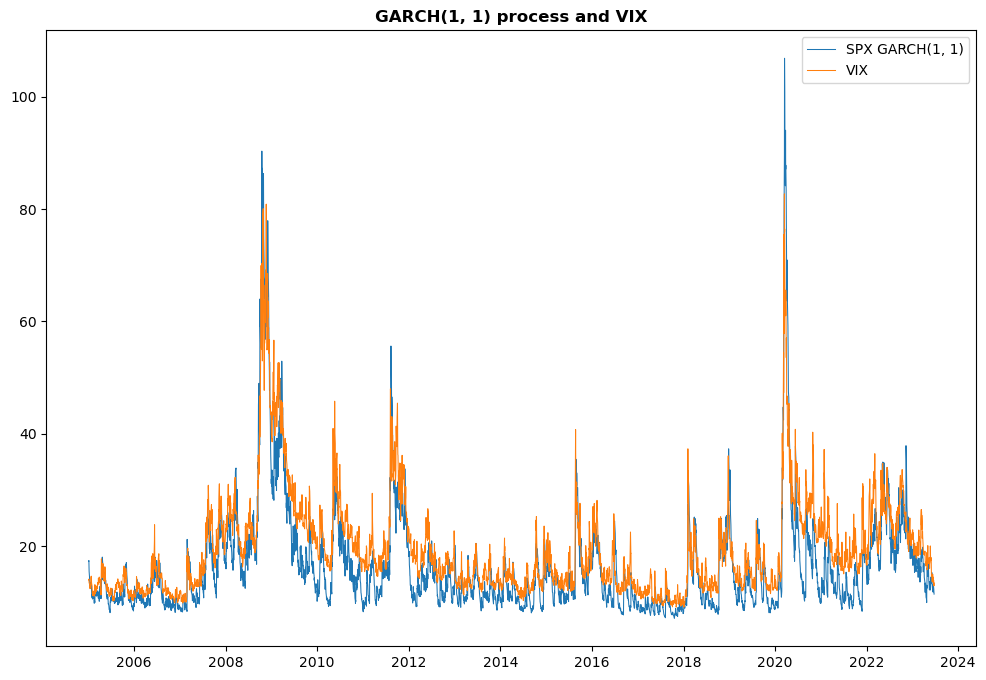

In [6]:
# 결과값을 데이터프레임으로 변환하고 연율화
res = pd.DataFrame(np.sqrt(modelSPX.sigma_2 * 252), index=SPX.index[1:])

# 그래프 시각화
plt.figure(figsize=(12, 8))
plt.plot(res, label='SPX GARCH(1, 1)', linewidth=0.75)
plt.plot(VIX.Close, label='VIX', linewidth=0.75)
plt.legend()
plt.title('GARCH(1, 1) process and VIX', fontweight='bold')

### arch 패키지를 활용한 GARCH 변동성 추정

In [7]:
# arch 패키지에서 arch_model 임포트
from arch import arch_model

# arch_model을 활용해 GARCH 모델 최적화 수행
arch_mSPX = arch_model(ret * 100, mean='Zero', vol='GARCH')
arch_mSPX = arch_mSPX.fit()

# 신뢰구간 추정
conf_int_SPX = pd.DataFrame(arch_mSPX.conf_int(alpha=0.2))

# 테스트 수행
conf_int_SPX['garchOneOne'] = modelSPX.coefficients[:-1]
conf_int_SPX['Test'] = np.where(conf_int_SPX['garchOneOne'] < conf_int_SPX['upper'], np.where(conf_int_SPX['garchOneOne'] > conf_int_SPX['lower'], 'OK', 'Not OK'), 'Not OK')

Iteration:      1,   Func. Count:      5,   Neg. LLF: 62247102.98340913
Iteration:      2,   Func. Count:     11,   Neg. LLF: 8742.355386209016
Iteration:      3,   Func. Count:     17,   Neg. LLF: 6399.431304705293
Iteration:      4,   Func. Count:     22,   Neg. LLF: 6276.700200100388
Iteration:      5,   Func. Count:     27,   Neg. LLF: 6457.939652283903
Iteration:      6,   Func. Count:     32,   Neg. LLF: 6260.190586868891
Iteration:      7,   Func. Count:     36,   Neg. LLF: 6260.157463957338
Iteration:      8,   Func. Count:     40,   Neg. LLF: 6260.156918453442
Iteration:      9,   Func. Count:     44,   Neg. LLF: 6260.156890889086
Iteration:     10,   Func. Count:     47,   Neg. LLF: 6260.156890887255
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6260.156890889086
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


In [8]:
# 테스트 결과
conf_int_SPX

,lower,upper,garchOneOne,Test
omega,0.018213,0.031936,0.025451,OK
alpha[1],0.109375,0.144855,0.126075,OK
beta[1],0.834670,0.871436,0.852437,OK
